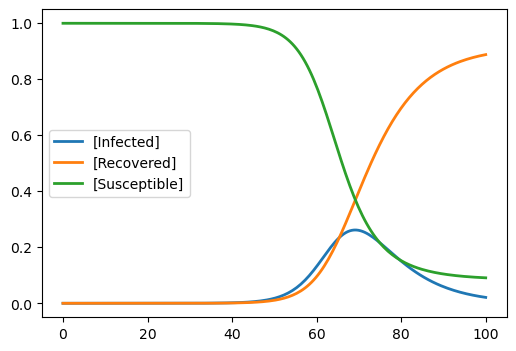

        time,  [Infected], [Recovered], [Susceptible]
 [[        0,  1.2639e-07,           0,             1],
  [ 0.502513, 1.42448e-07, 9.44562e-09,             1],
  [  1.00503, 1.60545e-07, 2.00912e-08,             1],
  [  1.50754, 1.80942e-07, 3.20894e-08,             1],
  [  2.01005,  2.0393e-07, 4.56115e-08,             1],
  [  2.51256, 2.29838e-07, 6.08518e-08,             1],
  [  3.01508, 2.59038e-07, 7.80283e-08,             1],
  [  3.51759, 2.91948e-07, 9.73868e-08,             1],
  [   4.0201, 3.29038e-07, 1.19205e-07,             1],
  [  4.52261, 3.70841e-07, 1.43795e-07,             1],
  [  5.02513, 4.17955e-07, 1.71508e-07,             1],
  [  5.52764, 4.71054e-07, 2.02743e-07,      0.999999],
  [  6.03015, 5.30899e-07, 2.37946e-07,      0.999999],
  [  6.53266, 5.98347e-07, 2.77622e-07,      0.999999],
  [  7.03518, 6.74364e-07, 3.22337e-07,      0.999999],
  [  7.53769, 7.60038e-07, 3.72734e-07,      0.999999],
  [   8.0402, 8.56597e-07, 4.29534e-07,      0.999

In [3]:
import tellurium as te
import time
import numpy as np
import matplotlib.pyplot as plt

model=te.loadSBMLModel("sbml_models/Bertozzi2020.xml")
a=time.time()
sol=model.simulate(0,100,200)
# b=time.time()
# print(b-a)


model.plot()
sol




In [18]:
model.getFullStoichiometryMatrix(
    
)

     R_expression, R_degradation, R_L_binding, C_degradation, C_I_binding, I_activation, X_degradation, A_degradation, I_expression, I_degradation
R [[            1,            -1,          -1,             0,           0,            0,             0,             0,            0,             0],
C  [            0,             0,           1,            -1,          -1,            1,             0,             0,            0,             0],
I  [            0,             0,           0,             0,          -1,            0,             0,             0,            1,            -1],
X  [            0,             0,           0,             0,           1,           -1,            -1,             0,            0,             0],
A  [            0,             0,           0,             0,           0,            1,             0,            -1,            0,             0]]

my_dict1 = {'key1': 'value1'}
my_dict2 = {'key2': 'value2'}
my_dict1.update(my_dict2)
print(my_dict1)  # Output:

In [5]:
my_dict1 = {'key1': 'value1'}
my_dict2 = {'key2': 'value2'}
my_dict1.update(my_dict2)
print(my_dict1)  # Output:

{'key1': 'value1', 'key2': 'value2'}


In [16]:
%timeit model.simulate(0,10,100)

48.2 µs ± 531 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
